In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import skimage.segmentation
from skimage import color
from pathlib import Path
from collections import defaultdict
from scipy.optimize import linear_sum_assignment

import imageio.core.util


def ignore_warnings(*args, **kwargs):
    pass
imageio.core.util._precision_warn = ignore_warnings

In [4]:
class Cell:

    # used for handling object information. Scalable.

    split_threshold = 1.8

    def __init__(self,contour,centroid,color = 0,id = -1):
        self.contour = contour # a set of (x,y) coordinates making up  a contour
        self.id = id
        self.centroid = centroid #(x,y) co-ordinates
        self.color = color
        self.underSplitting = False

    def get_contours(self):
        return self.contour


    def get_cell_id(self):
        return self.id

    def get_centroid(self):
        return self.centroid

    def get_under_splitting(self):
        return self.underSplitting

    def set_cell_id(self,new_id):
        self.id = new_id

    def set_under_splitting(self,flag):
        self.underSplitting = flag

    def if_splitting(self):
        (x,y),(a,b), angle = cv2.fitEllipse(self.contour)
        ratio = b / a

        if(ratio > self.split_threshold):
            self.set_under_splitting(True)


class Frame:

    def __init__(self, image):
        self.image = image
        self.cell_list = []
        self.trajectory = defaultdict(list)

class Match:

    distance_threshold = 50 # used for normalizing & threshold
    alpha_1 = 1
    alpha_2 = 0.5

    def __init__(self,frame_pre,frame_now):
        self.frame_pre = frame_pre
        self.frame_now = frame_now

    def set_distance_threshold(self,new_threshold):
        self.distance_threshold = new_threshold

    def set_distance_factor(self,new_factor):
        self.alpha_1 = new_factor

    def set_shape_factor(self,new_factor):
        self.alpha_2 = new_factor

    def cal_distance_cost(self,distance_thresh):

        size_pre = len(self.frame_pre.cell_list)
        size_now = len(self.frame_now.cell_list)

        distance_matrix = np.zeros((size_pre, size_now))

        # Euclidean Distance
        for i in range(size_pre):
            for j in range(size_now):
                x1, y1 = self.frame_pre.cell_list[i].centroid
                x2, y2 = self.frame_now.cell_list[j].centroid
                distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                distance_matrix[i][j] = distance / distance_thresh if distance < distance_thresh \
                    else 1

        return distance_matrix

    # def cal_cost_matrix(self):
    #     distance_matrix = self.cal_distance_cost(self.distance_threshold)
    #     cost_matrix = self.alpha_1 * distance_matrix

        # return  cost_matrix

    def match(self):
        distance_matrix = self.cal_distance_cost(self.distance_threshold)
        cost_matrix = self.alpha_1 * distance_matrix

        match_result = linear_sum_assignment(cost_matrix)
        # print(match_list)
        shape = np.shape(match_result)
        match_list = []
        for i in range(shape[1]):
            node_pre = match_result[0][i]
            node_now = match_result[1][i]
            if(distance_matrix[node_pre][node_now] == 1):
                continue
            match_list.append([node_pre,node_now])

        return match_list



frame_list = []
color_list = []
cell_id = 0
markers_color_value_offset = 10

def get_binary(
    input_image: np.array, 
    min_cell_pixel_portion = 1/8, 
    threshold_block_size = 35
):
    '''
    min_cell_pixel_portion: Decreasing this value will make smaller pixel value chunks considered as cell
    threshold_block_size: Increasing this value will let larger size of chunk being considered as cell, 
    but will lose detailed edges at the same time
    '''
    input = input_image.copy()
    # Get meaningful range
    meaningful_range = np.max(input) - np.min(input)
    # Assume certain small portion of the max_pixel_value is the minimum cell pixel value
    min_cell_pixel = math.ceil(meaningful_range * min_cell_pixel_portion)
    # normalize image based on the acquired meaningful range
    input_norm = cv2.normalize(input, None, alpha=0, beta=meaningful_range, norm_type=cv2.NORM_MINMAX)
    input_norm[input_norm < min_cell_pixel] = 0
    input_binary = cv2.adaptiveThreshold(
        input_norm,meaningful_range,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        threshold_block_size,
        0
    )
    return input_binary

def get_reduce_noise_by_closing(input_binary: np.array, kernel_size_closing = (5,5), iterations = 5):
    '''
    Try dilate and erode: closing
    1. Dilate the objects first to get rid of the noise inside each objects
    2. Erode the objects with same degree to decrease the size to original state
    '''
    input_closing = input_binary.copy()
    kernel = np.ones(kernel_size_closing,np.uint8)
    input_closing = cv2.morphologyEx(input_closing, cv2.MORPH_CLOSE, kernel, iterations)
    return input_closing

def get_reduce_noise_by_opening(input_binary: np.array, kernel_size_opening = (7,7), iterations = 5):
    '''
    Try erode and dilate: opening
    Erode then dilate
    '''
    input_opening = input_binary.copy()
    kernel = np.ones(kernel_size_opening,np.uint8)
    input_opening = cv2.morphologyEx(input_opening, cv2.MORPH_OPEN, kernel, iterations)
    return input_opening

def find_contours(
        input_image: np.array,
        input_binary: np.array, 
        kernel_size_bg = (3, 3),
        iterations_bg = 7,
        kernel_size_dist_erode = (3, 3),
        iterations_dist_erode = 4
    ):
    global markers_color_value_offset
    '''
    Find all of the contours of the input image cell and draw the contours
    '''
    kernel = np.ones(kernel_size_bg, np.uint8)
    sure_bg = cv2.dilate(input_binary, kernel, iterations=iterations_bg)
    dist_transform = cv2.distanceTransform(input_binary,cv2.DIST_MASK_3,5)
    dist_transform_erode = cv2.erode(dist_transform, kernel_size_dist_erode, iterations = iterations_dist_erode)
    sure_fg = np.uint8(dist_transform_erode)  #Convert to uint8 from float
    unknown = cv2.subtract(sure_bg,sure_fg)
    markers_amount, markers = cv2.connectedComponents(
        sure_fg, 
        4 # use connectivity of 4 instead of 8 to decrease close cells attaching probability
    )
    '''
    object_amount_not_on_borders:
    1. The total amount of objects detected in the image without considering the ones on borders
    2. Need to use markers_amount - 1 since markers_amount includes the background
    '''
    object_amount_not_on_borders = markers_amount - 1

    # make sure the background are not set as 0 and consider as unsured area
    markers = markers + markers_color_value_offset
    max_unkown = np.max(unknown)
    markers[unknown==max_unkown] = 0

    watershed = cv2.watershed(input_image, markers)

    # watershed boundaries are -1
    edges = np.zeros(input_binary.shape, np.uint8)
    edges[watershed == -1] = 1

    #label2rgb - Return an RGB image where color-coded labels are painted over the image.
    colored_segmentation = color.label2rgb(watershed, bg_label=0)

    return watershed, edges, colored_segmentation, object_amount_not_on_borders

def get_object_pixel_record(object_color_array):
    # Get useful pixel values
    unique_objects = np.unique(object_color_array)
    unique_objects = unique_objects[unique_objects >= 1] 

    # initialize the pixel dict with all object count starting from 0
    object_dict = dict.fromkeys(unique_objects)
    for key in object_dict:
        object_dict[key] = 0

    # get the pixel value count for each object key label
    for row in object_color_array:
        for col in row:
            if col >= 1:
                object_dict[col] += 1
    return object_dict

def format_name_digits(number: int):
    number_str = '000'
    if number < 10:
        number_str = '00' + str(number)
    elif number >= 10 and number <= 99: 
        number_str = '0' + str(number)
    elif number >= 100 and number <= 999:
        number_str = str(number)
    else:
        print("TOO BIG NUMBER for format_name_digits:", number)
    return number_str

def get_frame_info(path_cell: str):
    # Read as gray
    cell_original = cv2.imread(path_cell)
    cell = cv2.imread(path_cell, cv2.IMREAD_GRAYSCALE)

    # Turn into np array first
    cell = np.array(cell)

    # Grey image to binary
    cell_binary = get_binary(cell)

    # reduce noise
    cell_binary_opening = get_reduce_noise_by_opening(cell_binary)
    cell_no_noise = cell_binary_opening.copy()

    # removing border interfered cells
    cell_no_border = skimage.segmentation.clear_border(cell_no_noise)

    # get segmentation info WITH cells on boundaries considered
    cell_watershed, cell_edges, cell_colored_segmentation, cell_amount = find_contours(cell_original, cell_no_noise)

    # get segmentation info WITHOUT cells on boundaries considered
    cell_watershed_no_border, cell_edges_no_border, cell_colored_segmentation_no_border, cell_amount_no_border = find_contours(
        cell_original, cell_no_border)

    # After minus markers_color_value_offset, all of the objects color pixel will have value >= 1
    labels = np.unique(cell_watershed_no_border)

    cell_watershed_no_border = cell_watershed_no_border - markers_color_value_offset

    labels = np.unique(cell_watershed_no_border)
    cell_img = np.zeros_like(cell_no_border)
    cell_img[cell_no_border > 0] = 255
    cell_img = cv2.cvtColor(cell_img,cv2.COLOR_GRAY2RGB)

    frame = Frame(cell_img)
    for label in labels:
        if label <= 0:
            continue
        segment = np.zeros_like(cell_watershed_no_border)
        segment = np.uint8(segment)
        segment[cell_watershed_no_border == label] = 255
        contours, _ = cv2.findContours(segment, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        _, _, _, centroids = cv2.connectedComponentsWithStats(segment)
        cell = Cell(contours[0],centroids[1])

        # check if the cell is splitting
        cell.if_splitting()
        frame.cell_list.append(cell)

    return frame
'''
regu
'''
def register_new_cell(cell:Cell,cell_id):
    cell.set_cell_id(cell_id)
    cell.color = np.random.randint(low = 0,high =255,size = 3).tolist()
    global color_list
    color_list.append(cell.color)

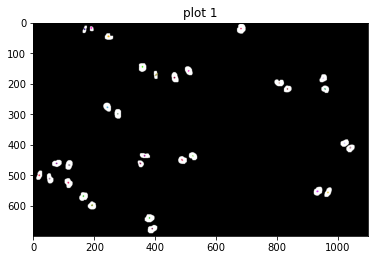

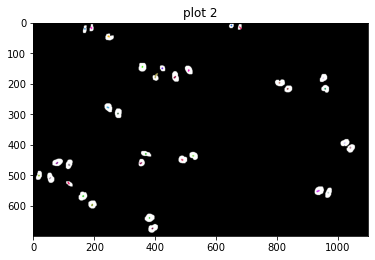

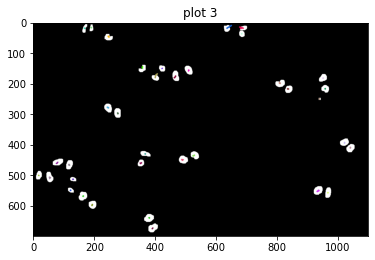

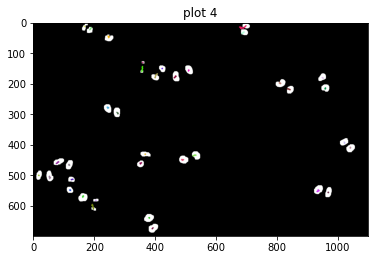

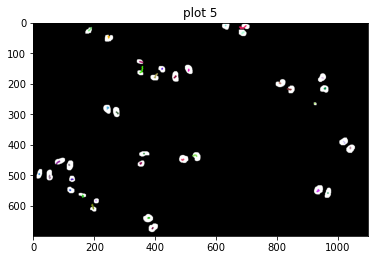

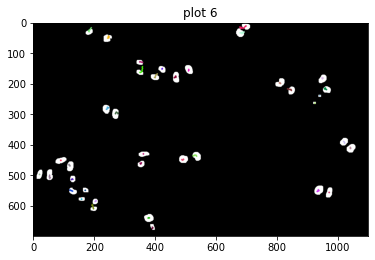

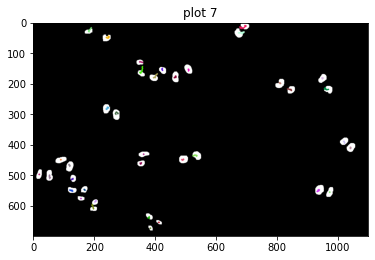

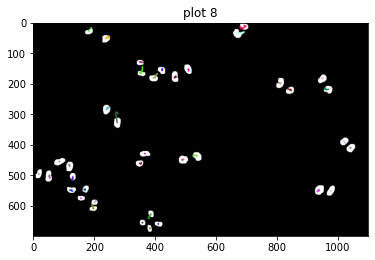

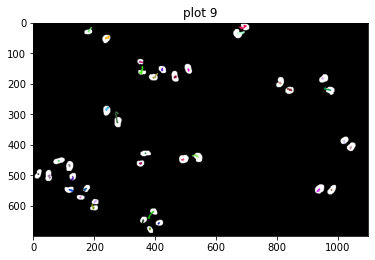

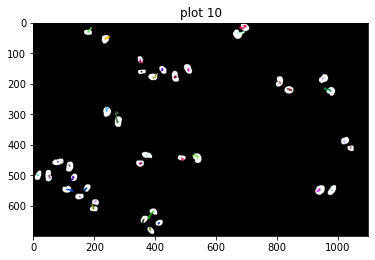

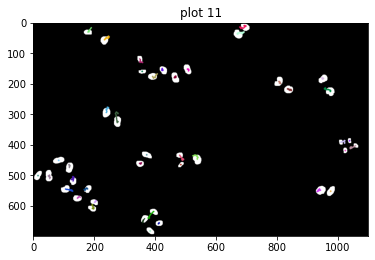

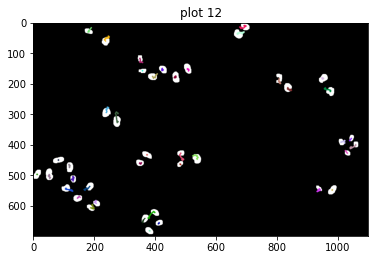

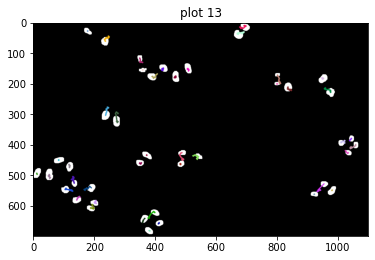

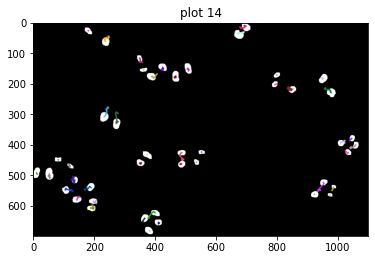

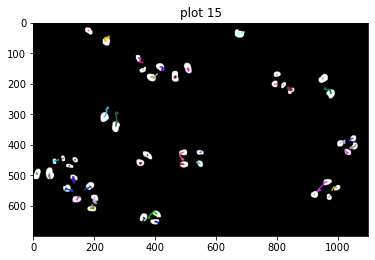

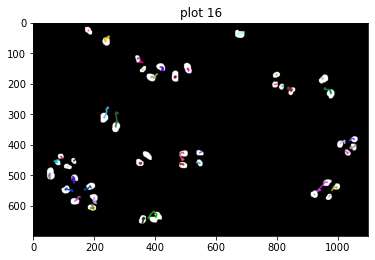

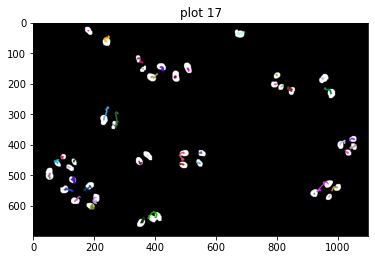

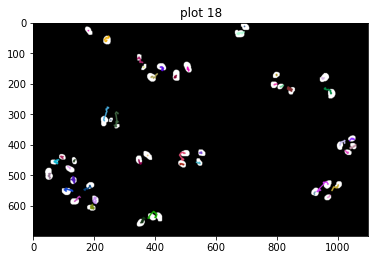

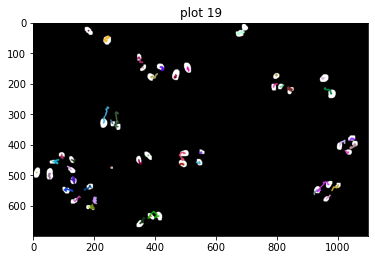

In [5]:
# Get image root path str(Path(file_path).parent.resolve()) + 
image_src_path = str(".\Sequences")
# individual image path example\
path_divide = "\\"
path_cell_subfolder = "01"
path_cell_name = "t000.tif"
path_cell = str(image_src_path + path_divide + path_cell_subfolder + path_divide + path_cell_name)


for i in range(0, 60):
    path_cell_subfolder = "01"
    path_cell_name = "t" + format_name_digits(i) + ".tif"
    path_cell = str(image_src_path + path_divide + path_cell_subfolder + path_divide + path_cell_name)
    now_frame = get_frame_info(path_cell)

    # first frame
    if(i == 0):
        for cell in now_frame.cell_list:
            register_new_cell(cell,cell_id)
            cell_id += 1
            now_frame.trajectory[cell.get_cell_id()].append(cell.get_centroid())

    # other frames
    elif (i < 60):
        pre_frame = frame_list[i-1]
        matcher = Match(pre_frame,now_frame)
        match_list = matcher.match()

        list_not_match_now = []
        list_match_now = []

        for j in range(len(match_list)):
            pre_index = match_list[j][0]
            now_index = match_list[j][1]

            pre_cell = pre_frame.cell_list[pre_index]
            now_cell = now_frame.cell_list[now_index]

            list_match_now.append(now_index)

            if (pre_cell.underSplitting) and  (now_cell.underSplitting):
                register_new_cell(now_cell,cell_id)
                cell_id +=1
                now_frame.trajectory[now_cell.id].append(now_cell.get_centroid())

            else:
                now_cell.id = pre_cell.id
                now_frame.trajectory[now_cell.id] = pre_frame.trajectory[pre_cell.id].copy()
                now_frame.trajectory[now_cell.id].append(now_cell.get_centroid())

        list_not_match_now = set([i for i in range(len(now_frame.cell_list))]) - set(list_match_now)

        for j in list_not_match_now:
            now_cell = now_frame.cell_list[j]
            register_new_cell(now_cell,cell_id)
            cell_id += 1
            now_frame.trajectory[now_cell.id].append(now_cell.get_centroid())
    else:
        break

    frame_list.append(now_frame)

for i in range(1,20):

    frame = frame_list[i]
    for key in frame.trajectory.keys():
        lines = frame.trajectory[key]

        if(len(lines) > 1):
            for j in range(len(lines)-1):
                x1,y1 = lines[j]
                x2,y2 = lines[j+1]

                cv2.line(frame.image, (int(x1), int(y1)), (int(x2), int(y2)), color_list[key], 3)
        else:
                x1,y1 = lines[0]
                cv2.circle(frame.image,(int(x1),int(y1)),1,color_list[key],3)

    plt.imshow(frame.image)

    plt.title(f'plot {i}')
    plt.show()